# Performance evaluation and benchmarking

In this notebook we will go step-by-step through the model evaluation part of our paper, as well as through the benchmarking part, where we compare our simulation results with a good hand-full of different (well-established) hydrological models.

For more information read the experiment description in our paper:

**TODO**: Include Ref

Note:
If you want to run this notebook locally and reproduce the figures of our paper
- make sure you have our pre-trained models. See the [README.md](link) in the repository for further instructions.

- make sure to have the CAMELS benchmark data set. See the [README.md](link) in the repository for further instructions.

#### Adapt the lines below according to your local system

In [15]:
# Needed if no precomputed results are used. Main directory containing all runs
BASE_RUN_DIR = "D:\\git\\ealstm_regional_modeling\\runs\\r2"

# Path to the benchmark model folders containing the basin netCDF files
DB_PATH = "D:\\git\\hydro-data\\catchment-data.sqlite3"

# Path to the main directory of this repository
BASE_CODE_DIR = "D:\\git\ealstm_regional_modeling"

In [16]:
# Imports
import pickle
import sys
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import tqdm
from scipy.stats import wilcoxon

# Add repository to Python path
sys.path.append(BASE_CODE_DIR)
from app.plotutils import model_draw_style, model_specs, ecdf
from app.evalutils import (get_run_dirs, eval_lstm_models,
                                 eval_benchmark_models, get_pvals, 
                                 get_mean_basin_performance, get_cohens_d)
from app.metrics import *

Definition of global variables. 

**Note**: If you want to recompute all model metrics, change the `PRECOMPUTED_DATA` flag to `False`. No GPU is required. If you want to use the pre-calculated metrics, make sure the flag is set to `True`

In [17]:
# If True load pre-computed metrics from pickle file, else re-calculate everything
PRECOMPUTED_DATA = False

# Convert to PosixPaths
BASE_RUN_DIR = Path(BASE_RUN_DIR)
DB_PATH = Path(DB_PATH)

# Set of evaluation functions
EVAL_FUNCS = {'NSE': calc_nse, 
              'alpha_nse': calc_alpha_nse, 
              'beta_nse': calc_beta_nse,
              'FHV': calc_fdc_fhv, 
              'FLV': calc_fdc_flv, 
              'FMS': calc_fdc_fms}

# Evaluate LSTM-based models

First, we compare the 6 different settings of LSTM-based models, that we trained for this paper. These are three different model settings:

1. EA-LSTM: Our proposed adaption of the LSTM recurrent neural network, where the static catchment characteristics are used to modulate the input gate.
2. LSTM: The standard LSTM architecture, where the static catchment characteristics are concatenated to the meterological inputs at each time step.
3. LSTM (no static inputs): A standard LSTM that is only trained using the meteorological forcing data.

All three model configurations were trained using two different loss functions:

1. MSELoss: The standard mean squared error loss.
2. NSELoss: Our proposed loss function, which approximates the basin averaged NSE. For more details see the Method section of our manuscript.

For each of the 6 settings, we trained 8 models (using different random initializations) and furthermore combined these 8 models to an ensemble (by averaging the k=8 model simulations)

In [18]:
if PRECOMPUTED_DATA:
    print("Loaded data from pre-computed pickle file")
    with open("all_metrics.p", "rb") as fp:
        all_metrics = pickle.load(fp)
else:
    all_metrics = {}
    for func_name, func in EVAL_FUNCS.items():
        tqdm.tqdm.write(f"Calculating metric: {func_name}")
        model_metrics = {}
        for model, specs in model_specs.items():
            run_dirs = get_run_dirs(root_dir=BASE_RUN_DIR, model=specs["model"], loss=specs["loss"])
            model_metrics[model] = eval_lstm_models(run_dirs=run_dirs, func=func)

        all_metrics[func_name] = model_metrics

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Calculating metric: NSE


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.13it/s]

Calculating metric: alpha_nse


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]

Calculating metric: beta_nse


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Calculating metric: FHV


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Calculating metric: FLV


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Calculating metric: FMS


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


## Tabular comparison

In a first step, we look at the mean, median NSE as well as the number of catastrophic failures. Catastrophic failures are defined as the number of basins, where the model has a NSE <= 0.
We calculate the mean of each of this three statistics over the model (n=8) model repetitions and report the standard deviation here as well. The repetitions are denoted as `ensemble=False` in the table below.

In [19]:
data = []
for model_type, models in all_metrics["NSE"].items():
    if model_type == "benchmarks":
        continue
    seeds = [k for k in models.keys() if "seed" in k]
    means, medians, failures = [], [], []
    for seed in seeds:
        nses = list(models[seed].values())
        means.append(np.mean(nses))
        medians.append(np.median(nses))
        failures.append(len([v for v in nses if v <= 0]))
    data_sing = {'model_type': model_draw_style[model_type]["label"], 
                 'ensemble': False, 
                 'mean': np.mean(means), 
                 'std_mean': np.std(means),
                 'median': np.mean(medians),
                 'std_median': np.std(medians),
                 'failures': np.mean(failures),
                 'std_failures': np.std(failures)}
    data.append(data_sing)
    values = list(models["ensemble"].values())
    data_ensemble = {'model_type': model_draw_style[model_type]["label"],
                   'ensemble': True,
                   'mean': np.mean(values),
                   'median': np.median(values),
                   'failures': len([v for v in values if v < 0]) }
    data.append(data_ensemble)

df = pd.DataFrame(data)
df = df.set_index(keys=["model_type", "ensemble"])
df

mean  std_mean     median  \
model_type                  ensemble                                     
EA-LSTM MSE                 False      -10.733926       0.0   0.452182   
                            True       -10.733926       NaN   0.452182   
EA-LSTM NSE                 False        0.600949       0.0   0.650381   
                            True         0.600949       NaN   0.650381   
LSTM MSE                    False       -4.119752       0.0   0.549334   
                            True        -4.119752       NaN   0.549334   
LSTM NSE                    False        0.645367       0.0   0.681873   
                            True         0.645367       NaN   0.681873   
LSTM (no static inputs) MSE False    -9678.776195       0.0 -11.425381   
                            True     -9678.776195       NaN -11.425381   
LSTM (no static inputs) NSE False       -1.650329       0.0  -0.207211   
                            True        -1.650329       NaN  -0.207211   

                                      std_median  failures  std_failures  
model_type                  ensemble                                      
EA-LSTM MSE                 False            0.0      47.0           0.0  
                            True             NaN      47.0           NaN  
EA-LSTM NSE                 False            0.0       6.0           0.0  
                            True             NaN       6.0           NaN  
LSTM MSE                    False            0.0      36.0           0.0  
                            True             NaN      36.0           NaN  
LSTM NSE                    False            0.0       2.0           0.0  
                            True             NaN       2.0           NaN  
LSTM (no static inputs) MSE False            0.0     153.0           0.0  
                            True             NaN     153.0           NaN  
LSTM (no static inputs) NSE False            0.0     141.0           0.0  
                            True             NaN     141.0           NaN

## Cumulative density function plot

Here we look at the CDF of the NSEs for each of our 6 configurations. 

- `solid` lines mark models trained with `NSELoss`, `dashed` lines mark models trained with `MSELoss`
- `saturated colors` are ensemble (n=8) means, `non-saturated colors` is a single model. Here we took seed 111 of each model, which is rather arbitrary but from the table above we seed that the mean/median NSE are robust between different random initializations.
- `square` marker denote models trained with static features, while `triangle` markers denote models trained without static features
- `green` is our proposed `EA-LSTM`, `orange` the standard LSTM with static features and `purple` the standard LSTM trained only on meteorological forcing data.

{'seed363233': {'01195100': -10.238116234032505, '01118300': -110.12247308075483, '01123000': -6.802962082048334, '01121000': -47.16959606550248, '01187300': 0.25048709588840434, '01181000': 0.5732618246411423, '01144000': 0.7438852480293527, '01052500': 0.6885186451105622, '01078000': 0.7579308410815687, '01142500': -2.4686261672956626, '01170100': 0.4202204664253911, '01073000': 0.360468747768962, '01162500': -0.6277822705056022, '01169000': 0.22393643874479052, '01030500': 0.751183853184578, '01013500': 0.8565703112978827, '01137500': -17.611955051961985, '02015700': 0.10286069087176786, '01031500': 0.7589077191786873, '01022500': 0.5901511967637446, '01054200': 0.4314870258595487, '04296000': 0.4404201841465941, '01055000': 0.20305740587836163, '01047000': 0.7274492440767655, '01057000': 0.4786571751961384, '01139000': 0.4315509705627666, '01139800': -245.11517413208614, '02016000': 0.4842510540264441, '01134500': -2.845714011214769, '01666500': -0.05492151074164542, '02018000': 0.

KeyError: 'seed111'

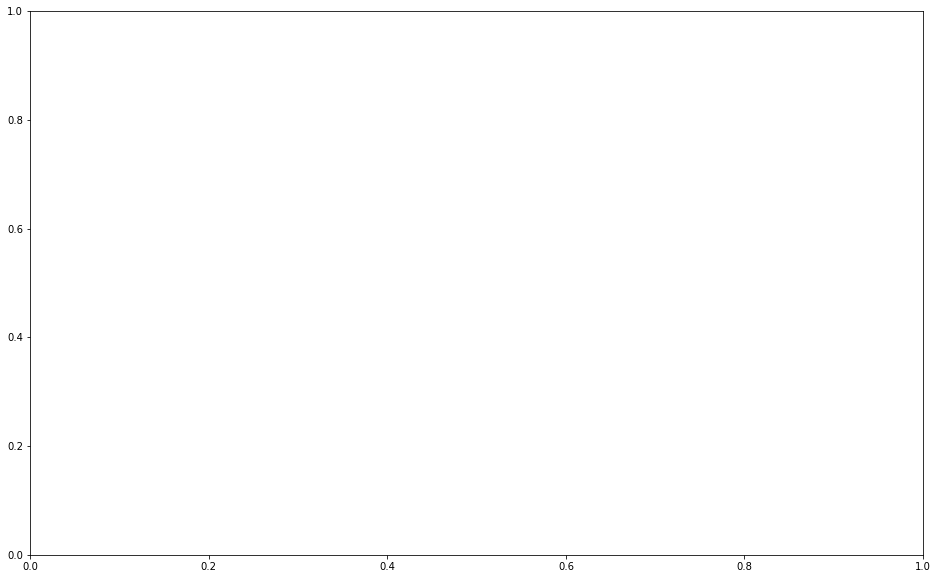

In [21]:
fig, ax = plt.subplots(figsize=(16,10))
# print(all_metrics["NSE"])
seed_label = "seed111"

for model_type, models in all_metrics["NSE"].items():
    if 'lstm' in model_type:
        # single seed
        print(models)
        values = list(models[seed_label].values())
        bin_, cdf_ = ecdf(values)
        ax.plot(bin_,
                cdf_,
                label=f"{model_draw_style[model_type]['label']} {seed_label}",
                color=model_draw_style[model_type]["single_color"], 
                marker=model_draw_style[model_type]['marker'], 
                markevery=20, 
                linestyle=model_draw_style[model_type]['linestyle'])
        
        # ensemble seed
        values = list(models['ensemble'].values())
        bin_, cdf_ = ecdf(values)
        ax.plot(bin_,
                cdf_, 
                label=f"{model_draw_style[model_type]['label']} ensemble (n=8)", 
                color=model_draw_style[model_type]['ensemble_color'], 
                linestyle=model_draw_style[model_type]['linestyle'])
    
ax.set_xlim(0, 1)
ax.grid(True)
ax.legend(loc='upper left')
ax.set_xlabel('NSE', fontsize=14)
ax.set_ylabel('cumulative density', fontsize=14)
ax.set_title("Effect of (not) using static catchment attributes", fontsize=18)

## Calculate statistical significance.

1. Calculate statistical significance between LSTM trained with and without static features using either MSE or NSE as loss function.

2. Calculate statistical significance between EA-LSTM and standard LSTM (with static features)

We always report the max, mean p-value between all possible seed combinations (n=8^2=64) as well as the p-value between the ensemble means

In [13]:
print("### NSE:")
print("With or without statics, optimized with MSE")
p_val_single, p_val_ensemble = get_pvals(all_metrics["NSE"], 
                                         model1='lstm_no_static_MSE', 
                                         model2='lstm_MSE')
print(f"Single models: p-value={p_val_single:.2e}")
print(f"Ensemble mean: {p_val_ensemble:.2e}")

print("\nWith or without statics, optimized with NSE")
p_val_single, p_val_ensemble = get_pvals(all_metrics["NSE"], 
                                         model1='lstm_no_static_NSE', 
                                         model2='lstm_NSE')
print(f"Single models: p-value={p_val_single:.2e}")
print(f"Ensemble mean: {p_val_ensemble:.2e}")

print("\nEA-LSTM vs LSTM (with statics), optimized with MSE")
p_val_single, p_val_ensemble = get_pvals(all_metrics["NSE"], 
                                         model1='lstm_MSE', 
                                         model2='ealstm_MSE')
print(f"Single models: p-value={p_val_single:.2e}")
print(f"Ensemble mean: {p_val_ensemble:.2e}")

print("\nEA-LSTM vs LSTM (with statics), optimized with NSE")
p_val_single, p_val_ensemble = get_pvals(all_metrics["NSE"], 
                                         model1='lstm_NSE', 
                                         model2='ealstm_NSE')
print(f"Single models: p-value={p_val_single:.2e}")
print(f"Ensemble mean: {p_val_ensemble:.2e}")

values1 = get_mean_basin_performance(all_metrics["NSE"], model="ealstm_NSE")
values1 = list(values1.values())
values2 = get_mean_basin_performance(all_metrics["NSE"], model="lstm_NSE")
values2 = list(values2.values())
d = get_cohens_d(values1, values2)
print(f"Effect size using Cohen's d is: d={d:.3f}")


print("\nEA-LSTM optimized with NSE vs. EA-LSTM optimized with MSE")
p_val_single, p_val_ensemble = get_pvals(all_metrics["NSE"], 
                                         model1='ealstm_NSE', 
                                         model2='ealstm_MSE')
print(f"Single models: p-value={p_val_single:.2e}")
print(f"Ensemble mean: {p_val_ensemble:.2e}")

print("\nLSTM  without static features optimized with NSE vs. optimized with MSE")
p_val_single, p_val_ensemble = get_pvals(all_metrics["NSE"], 
                                         model1='lstm_no_static_MSE', 
                                         model2='lstm_no_static_NSE')
print(f"Single models: p-value={p_val_single:.2e}")
print(f"Ensemble mean: {p_val_ensemble:.2e}")

### NSE:
With or without statics, optimized with MSE
Single models: p-value=4.14e-32
Ensemble mean: 4.14e-32

With or without statics, optimized with NSE
Single models: p-value=4.14e-32
Ensemble mean: 4.14e-32

EA-LSTM vs LSTM (with statics), optimized with MSE
Single models: p-value=1.67e-13
Ensemble mean: 1.67e-13

EA-LSTM vs LSTM (with statics), optimized with NSE
Single models: p-value=7.81e-10
Ensemble mean: 7.81e-10
Effect size using Cohen's d is: d=0.249

EA-LSTM optimized with NSE vs. EA-LSTM optimized with MSE
Single models: p-value=1.21e-16
Ensemble mean: 1.21e-16

LSTM  without static features optimized with NSE vs. optimized with MSE
Single models: p-value=4.99e-21
Ensemble mean: 4.99e-21


# Compare against benchmark models

Now we compare our model, the `EA-LSTM` optimized with `NSELoss`, against the set of benchmark models. Here, we only use the model results from the set of basins that were modeled by all models (the benchmark models and our models).

First, we have to calculate the metrics for all basins and benchmark models (or load the data from the precomputed file)

In [10]:
if not PRECOMPUTED_DATA:
    with open("all_metrics.p", "wb") as fp:
        pickle.dump(all_metrics, fp)
    print("Stored precomputed data in 'all_metrics.p'")

Stored precomputed data in 'all_metrics.p'


In [11]:
# find all basins modeled by all benchmarks
basins = frozenset(list(all_metrics["NSE"]["ealstm_NSE"]["ensemble"].keys()))
for model, results in all_metrics["NSE"]["benchmarks"].items():
    basins = basins.intersection(list(results.keys()))
len(basins)

KeyError: 'benchmarks'

In [12]:
# get subset of all metrics for these share basins
sub_metrics = {metric: defaultdict(dict) for metric in all_metrics.keys()}
for metric, model_metric in all_metrics.items():
    for model_type, models in model_metric.items():
        for model, results in models.items():
            sub_metrics[metric][model_type][model] = {}
            for basin, nse in results.items():
                if basin in basins:
                    sub_metrics[metric][model_type][model][basin] = nse

NameError: name 'sub_metrics' is not defined

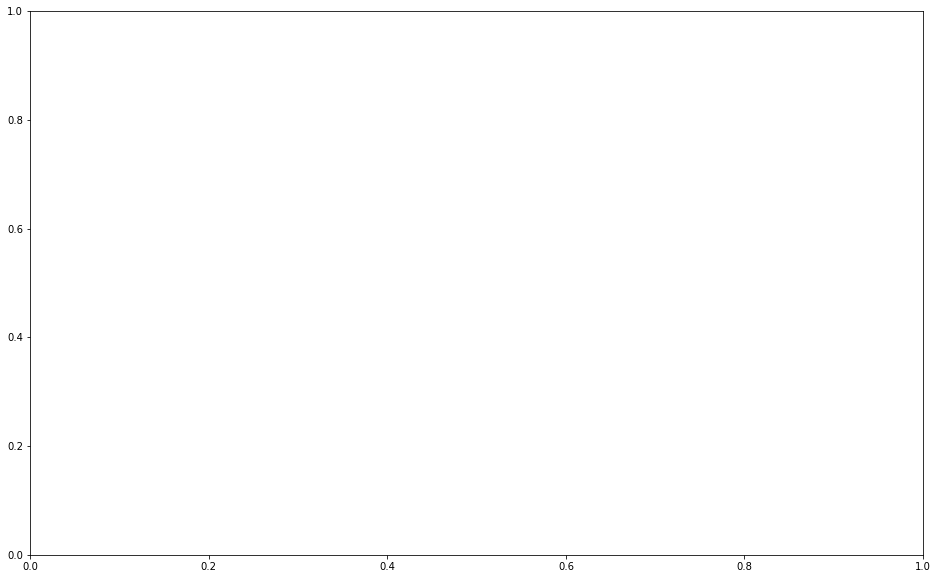

In [14]:
fig, ax = plt.subplots(figsize=(16,10))

for model_type, models in sub_metrics["NSE"].items():
    if (model_type == "ealstm_NSE") or (model_type == "lstm_no_static_NSE"):
        # single seed
        print(models.keys())
        values = list(models['seed111'].values())
        bin_, cdf_ = ecdf(values)
        ax.plot(bin_,
                cdf_,
                label=f"{model_draw_style[model_type]['label']} seed111",
                color=model_draw_style[model_type]["single_color"], 
                marker=model_draw_style[model_type]['marker'], 
                markevery=20, 
                linestyle=model_draw_style[model_type]['linestyle'])
        
        # ensemble seed
        values = list(models['ensemble'].values())
        bin_, cdf_ = ecdf(values)
        ax.plot(bin_,
                cdf_, 
                label=f"{model_draw_style[model_type]['label']} ensemble (n=8)", 
                color=model_draw_style[model_type]['ensemble_color'], 
                linestyle=model_draw_style[model_type]['linestyle'])
    elif model_type == "benchmarks":
        for benchmark_model, benchmark_result in models.items():
            if "conus" in benchmark_model:
                values = list(benchmark_result.values())
                bin_, cdf_ = ecdf(values)
                ax.plot(bin_,
                        cdf_, 
                        label=model_draw_style[benchmark_model]['label'], 
                        color=model_draw_style[benchmark_model]['color'], 
                        linestyle=model_draw_style[benchmark_model]['linestyle'])
    
ax.set_xlim(0, 1)
ax.grid(True)
ax.legend(loc='upper left')
ax.set_xlabel('NSE', fontsize=14)
ax.set_ylabel('cumulative density', fontsize=14)
ax.set_title("Benchmarking against CONUS-wide calibrated hydrological models", fontsize=18)

In [14]:
vic_count = 0
mhm_count = 0
for basin in basins:
    lstm_nse = sub_metrics["NSE"]["ealstm_NSE"]["ensemble"][basin]
    if sub_metrics["NSE"]["benchmarks"]["VIC_conus"][basin] >= lstm_nse:
        vic_count += 1
    if sub_metrics["NSE"]["benchmarks"]["mHm_conus"][basin] >= lstm_nse:
        mhm_count += 1
        
print(f"VIC is better (or equal) than EA-LSTM ensemble mean in {vic_count}/{len(basins)} basins")
print(f"mHm is better (or equal) than EA-LSTM ensemble mean in {mhm_count}/{len(basins)} basins")

KeyError: 'VIC_conus'

KeyError: 'seed111'

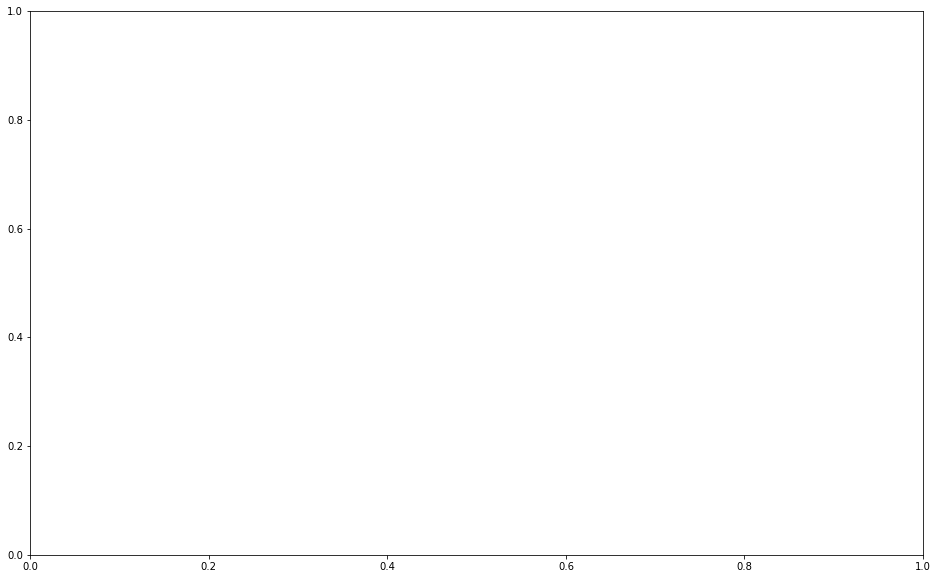

In [15]:
fig, ax = plt.subplots(figsize=(16,10))

for model_type, models in sub_metrics["NSE"].items():
    if model_type == "ealstm_NSE":
        # single seed
        values = list(models['seed111'].values())
        bin_, cdf_ = ecdf(values)
        ax.plot(bin_,
                cdf_,
                label=f"{model_draw_style[model_type]['label']} seed111",
                color=model_draw_style[model_type]["single_color"], 
                marker=model_draw_style[model_type]['marker'], 
                markevery=20, 
                linestyle=model_draw_style[model_type]['linestyle'])
        
        # ensemble seed
        values = list(models['ensemble'].values())
        bin_, cdf_ = ecdf(values)
        ax.plot(bin_,
                cdf_, 
                label=f"{model_draw_style[model_type]['label']} ensemble (n=8)", 
                color=model_draw_style[model_type]['ensemble_color'], 
                linestyle=model_draw_style[model_type]['linestyle'])
    elif model_type == "benchmarks":
        for benchmark_model, benchmark_result in models.items():
            if not "conus" in benchmark_model:
                values = list(benchmark_result.values())
                bin_, cdf_ = ecdf(values)
                ax.plot(bin_,
                        cdf_, 
                        label=model_draw_style[benchmark_model]['label'], 
                        color=model_draw_style[benchmark_model]['color'], 
                        linestyle=model_draw_style[benchmark_model]['linestyle'])
    
ax.set_xlim(0, 1)
ax.grid(True)
ax.legend(loc='upper left')
ax.set_xlabel('NSE', fontsize=14)
ax.set_ylabel('cumulative density', fontsize=14)
ax.set_title("Benchmarking against basin-wise calibrated hydrological models", fontsize=18)

In [16]:
data = []
single_model = {'model': 'EA-LSTM with NSE', 'ensemble': False}
ensemble_mean = {'model': 'EA-LSTM with NSE', 'ensemble': True}
# get EA-LSTM stats for all metrics
for metric, metric_data in sub_metrics.items():
    
    # average over single models
    seeds = [k for k in metric_data["ealstm_NSE"].keys() if "seed" in k]
    seed_vals = defaultdict(list)
    for seed in seeds:
        values = list(metric_data["ealstm_NSE"][seed].values())
        seed_vals[f"{metric} median"].append(np.median(values))
        if metric == "NSE":
            seed_vals[f"{metric} mean"].append(np.mean(values))
            seed_vals["failures"].append(len([v for v in values if v <= 0]))
        single_model[f"{metric} median"] = np.mean(seed_vals[f"{metric} median"])
        single_model[f"{metric} median std"] = np.std(seed_vals[f"{metric} median"])
        if metric == "NSE":
            single_model[f"{metric} mean"] = np.mean(seed_vals[f"{metric} mean"])
            single_model[f"{metric} mean std"] = np.std(seed_vals[f"{metric} mean"])
            single_model[f"failures"] = np.mean(seed_vals["failures"])
            single_model[f"failures std"] = np.std(seed_vals["failures"])
            
    # ensemble mean
    values = list(metric_data["ealstm_NSE"]["ensemble"].values())
    ensemble_mean[f"{metric} median"] = np.median(values)
    if metric == "NSE":
        ensemble_mean["NSE mean"] = np.mean(values)
        ensemble_mean["failures"] = len([v for v in values if v <= 0])
        
data.append(single_model)
data.append(ensemble_mean)
        
# benchmark models:
for model in model_draw_style.keys():
    if "lstm" in model:
        continue
    model_data = {"model": model_draw_style[model]["label"], "ensemble": False}
    for metric, metric_data in sub_metrics.items():
        values = list(metric_data["benchmarks"][model].values())
        model_data[f"{metric} median"] = np.median(values)
        if metric == "NSE":
            model_data["NSE mean"] = np.mean(values)
            model_data["failures"] = len([v for v in values if v <= 0])
            
    data.append(model_data)
        
df = pd.DataFrame(data)
df = df.set_index(keys=["model", "ensemble"])
df

KeyError: 'SAC_SMA'

In [17]:
df.to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th></th>\n      <th>mean</th>\n      <th>std_mean</th>\n      <th>median</th>\n      <th>std_median</th>\n      <th>failures</th>\n      <th>std_failures</th>\n    </tr>\n    <tr>\n      <th>model_type</th>\n      <th>ensemble</th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th rowspan="2" valign="top">EA-LSTM MSE</th>\n      <th>False</th>\n      <td>-8.570622</td>\n      <td>0.0</td>\n      <td>0.442068</td>\n      <td>0.0</td>\n      <td>51.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th>True</th>\n      <td>-8.570622</td>\n      <td>NaN</td>\n      <td>0.442068</td>\n      <td>NaN</td>\n      <td>51.0</td>\n      <td>NaN</td>\n    </tr>\n    <tr>\n      <th rowspan="2" valign="top">EA-LSTM NSE</th>\n      <th>False</th>\n      <td>0.587154</td>\n      <t

In [16]:
for metric in sub_metrics.keys():
    print(f"\n\n#### {metric}")
    print(f"Comparison between EA-LSTM (optimized with NSE) and mHm (basin-wise calibrated)")
    ealstm_perf = get_mean_basin_performance(sub_metrics[metric], model="ealstm_NSE")
    _, p_val_single = wilcoxon(list(ealstm_perf.values()),
                               list(sub_metrics[metric]["benchmarks"]["mHm_basin"].values()))
    _, p_val_ensemble = wilcoxon(list(sub_metrics[metric]["benchmarks"]["mHm_basin"].values()), 
                                 list(sub_metrics[metric]["ealstm_NSE"]["ensemble"].values()))
    print(f"For single models: {p_val_single:.2e}")
    print(f"For ensemble mean {p_val_ensemble:.2e}")
    d_single = get_cohens_d(list(ealstm_perf.values()),
                            list(sub_metrics[metric]["benchmarks"]["mHm_basin"].values()))
    d_ensemble = get_cohens_d(list(sub_metrics[metric]["benchmarks"]["mHm_basin"].values()), 
                              list(sub_metrics[metric]["ealstm_NSE"]["ensemble"].values()))
    print(f"Effect size: Single model d={d_single:.3f}, ensemble mean d={d_ensemble:.3f}")


    print(f"\nComparison between EA-LSTM (optimized with NSE) and HBV (upper limit)")
    _, p_val_single = wilcoxon(list(ealstm_perf.values()),
                               list(sub_metrics[metric]["benchmarks"]["HBV_ub"].values()))
    _, p_val_ensemble = wilcoxon(list(sub_metrics[metric]["benchmarks"]["HBV_ub"].values()), 
                                 list(sub_metrics[metric]["ealstm_NSE"]["ensemble"].values()))
    print(f"For single models: {p_val_single:.2e}")
    print(f"For ensemble mean {p_val_ensemble:.2e}")
    d_single = get_cohens_d(list(ealstm_perf.values()),
                            list(sub_metrics[metric]["benchmarks"]["HBV_ub"].values()))
    d_ensemble = get_cohens_d(list(sub_metrics[metric]["benchmarks"]["HBV_ub"].values()), 
                              list(sub_metrics[metric]["ealstm_NSE"]["ensemble"].values()))
    print(f"Effect size: Single model d={d_single:.3f}, ensemble mean d={d_ensemble:.3f}")



#### NSE
Comparison between EA-LSTM (optimized with NSE) and mHm (basin-wise calibrated)
For single models: 4.29e-06
For ensemble mean 1.01e-13
Effect size: Single model d=0.256, ensemble mean d=0.445

Comparison between EA-LSTM (optimized with NSE) and HBV (upper limit)
For single models: 1.90e-04
For ensemble mean 6.21e-11
Effect size: Single model d=0.224, ensemble mean d=0.404


#### alpha_nse
Comparison between EA-LSTM (optimized with NSE) and mHm (basin-wise calibrated)
For single models: 1.84e-01
For ensemble mean 7.82e-01
Effect size: Single model d=0.049, ensemble mean d=0.047

Comparison between EA-LSTM (optimized with NSE) and HBV (upper limit)
For single models: 3.88e-02
For ensemble mean 5.33e-01
Effect size: Single model d=0.106, ensemble mean d=0.016


#### beta_nse
Comparison between EA-LSTM (optimized with NSE) and mHm (basin-wise calibrated)
For single models: 3.24e-03
For ensemble mean 3.24e-03
Effect size: Single model d=0.189, ensemble mean d=0.189

Comparison be